# Setup

## Install

In [1]:
!pip install awswrangler
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.6/380.6 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 7.1 MB/s eta 0:00:00


## Import

In [2]:
import pandas as pd
import awswrangler as wr
import boto3
import numpy as np
import matplotlib.pyplot as plt
from getpass import getpass
import os

In [3]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset

## Constants

In [32]:
# --- IMPORTANT: Set these variables before running ---
AWS_REGION = 'us-east-2'
S3_STAGING_DIR = 's3://cs230-market-data-2025/athena-query-results/'
ATHENA_DB = 'cs230_finance_data'
# Querying more data for a small training run
# SQL_QUERY = "SELECT concatarticles1, concatarticles2, vol_1_vs_2 FROM paired_vixy_w_titles_v3 WHERE vol_1_vs_2 is not null ORDER BY RAND() LIMIT 10000"
# SQL_QUERY = "SELECT concatarticles1, concatarticles2, open_lead_close_lag_change_pct_bucket1 as bucket1, open_lead_close_lag_change_pct_bucket2 as bucket2, samebucket_open_lead_close_lag_change_pct as samebucket FROM paired_vixy_w_titles_dedupped ORDER BY RAND() LIMIT 10000"
SQL_QUERY_NEWS = "SELECT * FROM fnspid_nasdaq_news_top5_summaries"
SQL_QUERY_STOCKS = "SELECT * FROM fnspid_stock_prices_top5"

INPUT_FEATURES = ['open', 'close', 'volume','sentiment_score']
SEQ_LEN = 50 # Small for this dummy data, use 30 or 60 for real usage
FUTURE_LEN = 3

# ----------------------------------------------------


## Connect AWS

In [5]:
# --- AWS Authentication for Colab ---
# Prompt for AWS credentials
aws_access_key_id = getpass('Enter AWS Access Key ID: ')
aws_secret_access_key = getpass('Enter AWS Secret Access Key: ')


Enter AWS Access Key ID: ··········
Enter AWS Secret Access Key: ··········


# Preprocessing

## Read data from aws

In [34]:


print(f"\n--- Step 3: Configuration set for {ATHENA_DB} ---")
print(f"--- Step 4: Querying Data ---")
print(f"Querying data from {ATHENA_DB}....")

# Define df in a wider scope
df_news = None
df_stocks = None

try:
    # Create a boto3 session with the provided credentials
    session = boto3.Session(
        aws_access_key_id=aws_access_key_id,
        aws_secret_access_key=aws_secret_access_key,
        region_name=AWS_REGION,
    )

    # Run the query and load results into a Pandas DataFrame
    df_news = wr.athena.read_sql_query(
        sql=SQL_QUERY_NEWS,
        database=ATHENA_DB,
        s3_output=S3_STAGING_DIR,
        boto3_session=session,
    )

    df_stocks = wr.athena.read_sql_query(
        sql=SQL_QUERY_STOCKS,
        database=ATHENA_DB,
        s3_output=S3_STAGING_DIR,
        boto3_session=session,
    )
    SQL_QUERY_STOCKS

    print("\nQuery successful! Data loaded into DataFrame.")



except Exception as e:
    print(f"\nAn error occurred:")
    print(e)


--- Step 3: Configuration set for cs230_finance_data ---
--- Step 4: Querying Data ---
Querying data from cs230_finance_data....

Query successful! Data loaded into DataFrame.


## Process stock price

In [35]:
df = df_stocks.copy()
df['date'] = pd.to_datetime(df['date']).dt.normalize()

In [36]:
# Helper function to create sequences
def create_sequences(features, target, lookback=50, horizon=3):
    X, y = [], []
    # We create sequences of length 'lookback'
    # The target is 'horizon' steps after the sequence ends
    # Sequence ends at index i + lookback - 1
    # Target index is (i + lookback - 1) + horizon
    for i in range(len(features) - lookback - horizon + 1):
        X.append(features[i : i + lookback])
        y.append(target[i + lookback + horizon - 1])
    return np.array(X), np.array(y)

# Initialize containers
X_train_all, y_train_all = [], []
X_test_all, y_test_all = [], []
scalers = {}

# Get unique stock symbols
unique_symbols = df['stock_symbol'].unique()

print(f"Processing {len(unique_symbols)} stocks...")

for symbol in unique_symbols:
    # Filter and sort by date
    stock_data = df[df['stock_symbol'] == symbol].sort_values('date')

    # Select features
    features = stock_data[['open', 'close', 'volume']].values

    if len(features) == 0:
        continue

    # Split into train (80%) and test (20%)
    split_idx = int(len(features) * 0.8)
    train_features = features[:split_idx]
    test_features = features[split_idx:]

    # Scale features
    scaler = MinMaxScaler()
    # Fit on training data, transform both
    train_scaled = scaler.fit_transform(train_features)
    test_scaled = scaler.transform(test_features)

    # Store the scaler
    scalers[symbol] = scaler

    # Extract the target column ('close' is at index 1)
    train_target = train_scaled[:, 1]
    test_target = test_scaled[:, 1]

    # Create sequences
    X_tr, y_tr = create_sequences(train_scaled, train_target, lookback=50, horizon=3)
    X_te, y_te = create_sequences(test_scaled, test_target, lookback=50, horizon=3)

    # Append to lists if sequences were created
    if len(X_tr) > 0:
        X_train_all.append(X_tr)
        y_train_all.append(y_tr)
    if len(X_te) > 0:
        X_test_all.append(X_te)
        y_test_all.append(y_te)

# Concatenate all sequences
if X_train_all:
    X_train = np.concatenate(X_train_all, axis=0)
    y_train = np.concatenate(y_train_all, axis=0)
else:
    X_train, y_train = np.array([]), np.array([])

if X_test_all:
    X_test = np.concatenate(X_test_all, axis=0)
    y_test = np.concatenate(y_test_all, axis=0)
else:
    X_test, y_test = np.array([]), np.array([])

# Print final shapes
print("Data preparation complete.")
print(f"X_train shape: {X_train.shape}")
print(f"ç shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

Processing 5 stocks...
Data preparation complete.
X_train shape: (30320, 50, 3)
ç shape: (30320,)
X_test shape: (7387, 50, 3)
y_test shape: (7387,)


## Get sentiment score

## calculate

In [37]:
# import torch
# from transformers import BertTokenizer, BertForSequenceClassification
# from tqdm import tqdm
# import pandas as pd

# news_df = df_news.copy()
# # 1. Check for GPU availability
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# # 2. Load Model and Tokenizer
# MODEL_NAME = "ProsusAI/finbert"
# tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
# model = BertForSequenceClassification.from_pretrained(MODEL_NAME)
# model.to(device)
# model.eval()

# # 3. Inspect labels to identify indices
# label_map = model.config.id2label
# print(f"Model Label Map: {label_map}")

# # Find indices for each sentiment
# idx_pos = next(k for k, v in label_map.items() if v.lower() == 'positive')
# idx_neg = next(k for k, v in label_map.items() if v.lower() == 'negative')
# idx_neu = next(k for k, v in label_map.items() if v.lower() == 'neutral')

# print(f"Indices -> Positive: {idx_pos}, Negative: {idx_neg}, Neutral: {idx_neu}")

# # 4 & 5. Process lsa_summary in batches
# batch_size = 32
# summaries = news_df['lsa_summary'].astype(str).tolist()
# sentiment_scores = []

# print(f"Processing {len(summaries)} summaries...")

# for i in tqdm(range(0, len(summaries), batch_size)):
#     batch_texts = summaries[i:i+batch_size]

#     # Tokenize
#     inputs = tokenizer(
#         batch_texts,
#         return_tensors="pt",
#         padding=True,
#         truncation=True,
#         max_length=512
#     ).to(device)

#     # Inference
#     with torch.no_grad():
#         outputs = model(**inputs)
#         probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
#         probs = probs.cpu().numpy()

#     # Calculate scores for the batch
#     # Formula: (P_neg * 1.0) + (P_neu * 3.0) + (P_pos * 5.0)
#     for prob in probs:
#         score = (prob[idx_neg] * 1.0) + (prob[idx_neu] * 3.0) + (prob[idx_pos] * 5.0)
#         sentiment_scores.append(score)

# # 6. Store scores in DataFrame
# news_df['sentiment_score'] = sentiment_scores

# # 7. Aggregate by day and stock
# # Ensure timestamp is datetime if not already (it looked like string in head() output)
# if news_df['timestamp'].dtype == 'object':
#     news_df['timestamp'] = pd.to_datetime(news_df['timestamp'])

# # Normalize to date (remove time component) before grouping
# news_df['timestamp'] = news_df['timestamp'].dt.normalize()

# sentiment_daily = news_df.groupby(['stock_symbol', 'timestamp'])['sentiment_score'].mean().reset_index()

# # 8. Verify results
# print("\naggregated sentiment_daily dataframe:")
# print(sentiment_daily.head())

## Save or load sentiment score

In [38]:
import os
import pandas as pd # Ensure pandas is imported if not already

CHECKPOINT_FILENAME = "sentiment_daily_checkpoint.csv"

# 1. Check if sentiment_daily is defined in memory
if 'sentiment_daily' in locals() and sentiment_daily is not None:
    print(f"Saving 'sentiment_daily' to {CHECKPOINT_FILENAME}...")
    sentiment_daily.to_csv(CHECKPOINT_FILENAME, index=False)
    print("Save complete.")

# 2. If not in memory, try to reload from file
else:
    if os.path.exists(CHECKPOINT_FILENAME):
        print(f"'sentiment_daily' not found in memory. Reloading from {CHECKPOINT_FILENAME}...")
        sentiment_daily = pd.read_csv(CHECKPOINT_FILENAME)
        # Ensure timestamp is datetime
        sentiment_daily['timestamp'] = pd.to_datetime(sentiment_daily['timestamp'])
        print("Reload complete.")
    else:
        print("Warning: 'sentiment_daily' is missing and no checkpoint file found. Please run the sentiment inference step first.")

# Verify the dataframe
if 'sentiment_daily' in locals():
    print(sentiment_daily.head())

Saving 'sentiment_daily' to sentiment_daily_checkpoint.csv...
Save complete.
  stock_symbol  timestamp  sentiment_score
0         AAPL 2022-06-03         1.624226
1         AAPL 2022-06-04         2.992088
2         AAPL 2022-06-05         4.057425
3         AAPL 2022-06-06         2.994555
4         AAPL 2022-06-07         2.938732


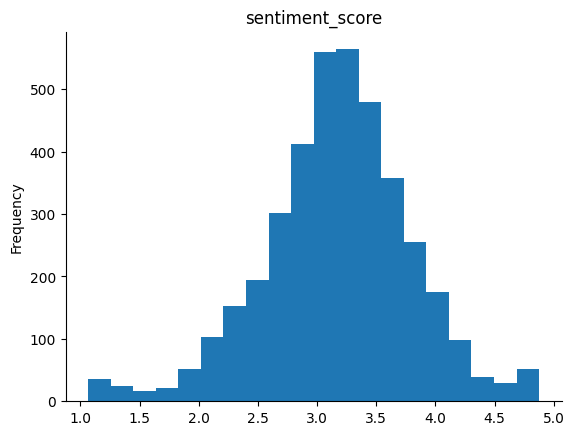

In [39]:
from matplotlib import pyplot as plt
sentiment_daily['sentiment_score'].plot(kind='hist', bins=20, title='sentiment_score')
plt.gca().spines[['top', 'right',]].set_visible(False)

## sentiment score fusioned tensors

In [40]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 1. Setup constants
alpha = np.exp(-0.03)
neutral_score = 3.0
lookback = 50
horizon = 3

# 2. Prepare DataFrames
# Use copies to ensure clean state
df = df_stocks.copy()
df['date'] = pd.to_datetime(df['date']).dt.normalize()
# Ensure numeric features
for col in ['open', 'close', 'volume']:
    df[col] = pd.to_numeric(df[col], errors='coerce')
# Clean stock_symbol
df['stock_symbol'] = df['stock_symbol'].astype(str).str.strip().str.lower()

# Prepare sentiment data
sentiment_prep = sentiment_daily.copy()
if 'timestamp' in sentiment_prep.columns:
    sentiment_prep.rename(columns={'timestamp': 'date'}, inplace=True)
sentiment_prep['date'] = pd.to_datetime(sentiment_prep['date']).dt.normalize()
# Clean stock_symbol
sentiment_prep['stock_symbol'] = sentiment_prep['stock_symbol'].astype(str).str.strip().str.lower()

# Merge and Sort
# Left join to keep all stock records
df_merged = pd.merge(df, sentiment_prep, on=['stock_symbol', 'date'], how='left')
df_merged = df_merged.sort_values(['stock_symbol', 'date']).reset_index(drop=True)

# Verify Merge
n_matches = df_merged['sentiment_score'].notna().sum()
print(f"Merge complete. Found {n_matches} rows with sentiment scores.")
if n_matches == 0:
    print("WARNING: No sentiment scores matched! Check stock_symbol formats or date ranges.")

# 3. Initialize containers
X_train_all, y_train_all = [], []
X_test_all, y_test_all = [], []

# Helper function for recursive decay imputation
def impute_decay(values, start_val, alpha, neutral):
    imputed = []
    current = start_val
    for v in values:
        if np.isnan(v):
            current = alpha * current + (1 - alpha) * neutral
        else:
            current = v
        imputed.append(current)
    return np.array(imputed)

print(f"Processing {len(df_merged['stock_symbol'].unique())} stocks with strict split & recursive imputation...")

# 4. Iterate per stock
for symbol, group in df_merged.groupby('stock_symbol'):
    # a. Extract features: Open, Close, Volume, Sentiment
    raw_data = group[['open', 'close', 'volume', 'sentiment_score']].values

    # Skip if too short
    if len(raw_data) < (lookback + horizon + 1):
        continue

    # b. Split raw data (80% Train, 20% Test)
    split_idx = int(len(raw_data) * 0.8)
    train_raw = raw_data[:split_idx]
    test_raw = raw_data[split_idx:]

    # c. Imputation
    # --- Train Imputation ---
    train_sent = train_raw[:, 3].astype(float)
    # If starts with NaN, initialize with neutral
    if np.isnan(train_sent[0]):
        train_sent[0] = neutral_score

    train_sent_imputed = impute_decay(train_sent, neutral_score, alpha, neutral_score)
    train_raw[:, 3] = train_sent_imputed

    # --- Test Imputation ---
    last_train_score = train_sent_imputed[-1]
    test_sent = test_raw[:, 3].astype(float)
    test_sent_imputed = impute_decay(test_sent, last_train_score, alpha, neutral_score)
    test_raw[:, 3] = test_sent_imputed

    # d. Scaling
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_raw)
    test_scaled = scaler.transform(test_raw)

    # e. Sequence Generation
    train_target = train_scaled[:, 1]
    test_target = test_scaled[:, 1]

    X_tr, y_tr = create_sequences(train_scaled, train_target, lookback, horizon)
    X_te, y_te = create_sequences(test_scaled, test_target, lookback, horizon)

    # f. Append
    if len(X_tr) > 0:
        X_train_all.append(X_tr)
        y_train_all.append(y_tr)
    if len(X_te) > 0:
        X_test_all.append(X_te)
        y_test_all.append(y_te)

# 5. Concatenate
if X_train_all:
    X_train = np.concatenate(X_train_all, axis=0)
    y_train = np.concatenate(y_train_all, axis=0)
else:
    X_train, y_train = np.array([]), np.array([])

if X_test_all:
    X_test = np.concatenate(X_test_all, axis=0)
    y_test = np.concatenate(y_test_all, axis=0)
else:
    X_test, y_test = np.array([]), np.array([])

# 6. Print Shapes
print("Strict Train/Test Split & Imputation Complete.")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

Merge complete. Found 2789 rows with sentiment scores.
Processing 5 stocks with strict split & recursive imputation...
Strict Train/Test Split & Imputation Complete.
X_train shape: (30320, 50, 4)
y_train shape: (30320,)
X_test shape: (7387, 50, 4)
y_test shape: (7387,)


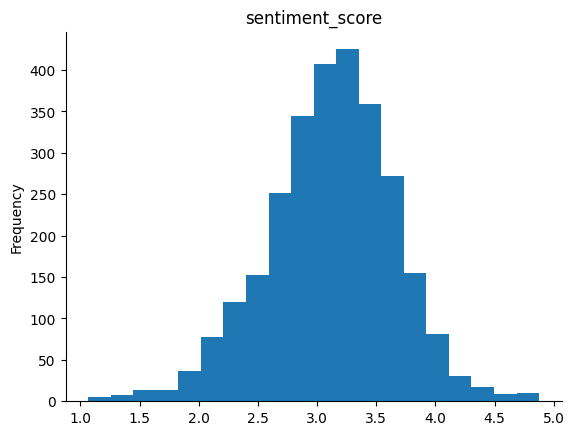

In [41]:
from matplotlib import pyplot as plt
df_merged['sentiment_score'].plot(kind='hist', bins=20, title='sentiment_score')
plt.gca().spines[['top', 'right',]].set_visible(False)

Total rows: 38227
Rows with sentiment: 2789
Percentage with sentiment: 7.30%


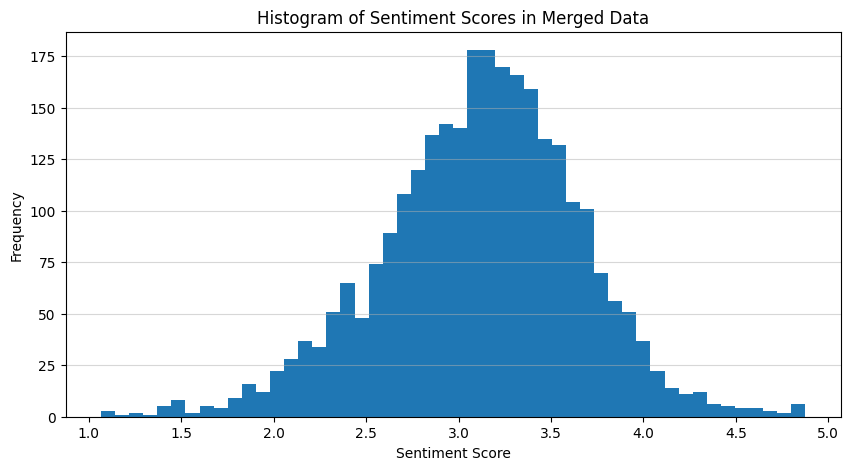

In [42]:
import matplotlib.pyplot as plt

# Calculate coverage
total_rows = len(df_merged)
with_sentiment = df_merged['sentiment_score'].count()
percent = (with_sentiment / total_rows) * 100

print(f"Total rows: {total_rows}")
print(f"Rows with sentiment: {with_sentiment}")
print(f"Percentage with sentiment: {percent:.2f}%")

# Plot histogram
plt.figure(figsize=(10, 5))
df_merged['sentiment_score'].plot(kind='hist', bins=50, title='Histogram of Sentiment Scores in Merged Data')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.5)
plt.show()

Sentiment Coverage Statistics per Stock:
  stock_symbol  total_rows  rows_with_sentiment  percentage
0         aapl       10852                  387    3.566163
1         amzn        6700                  192    2.865672
2         goog        4874                 1211   24.846122
3         msft        9526                  414    4.346000
4         nvda        6275                  585    9.322709


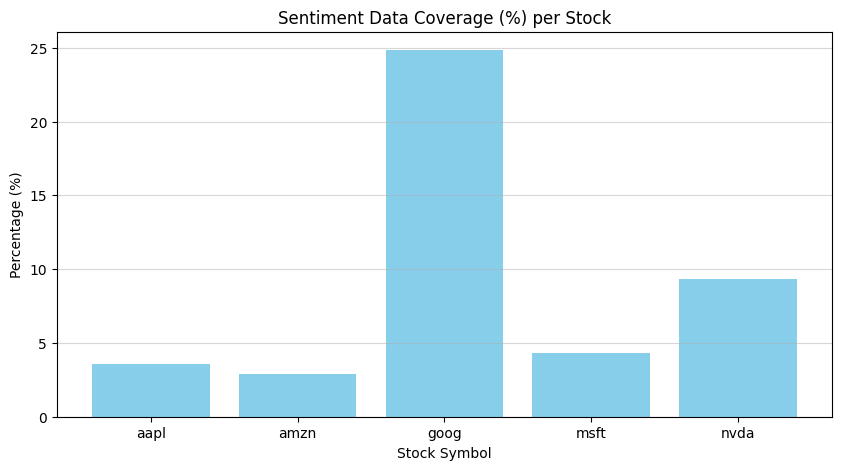

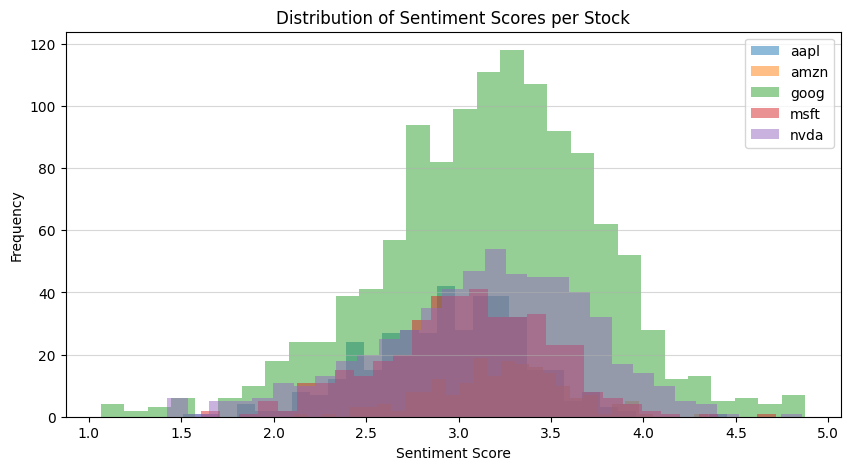

In [43]:
import matplotlib.pyplot as plt

# Calculate coverage per stock
# 'size' counts total rows, 'count' counts non-null values in the column
stats = df_merged.groupby('stock_symbol')['sentiment_score'].agg(['size', 'count']).reset_index()
stats.columns = ['stock_symbol', 'total_rows', 'rows_with_sentiment']
stats['percentage'] = (stats['rows_with_sentiment'] / stats['total_rows']) * 100

print("Sentiment Coverage Statistics per Stock:")
print(stats)

# Plot 1: Bar chart of coverage percentage
plt.figure(figsize=(10, 5))
plt.bar(stats['stock_symbol'], stats['percentage'], color='skyblue')
plt.title('Sentiment Data Coverage (%) per Stock')
plt.xlabel('Stock Symbol')
plt.ylabel('Percentage (%)')
plt.grid(axis='y', alpha=0.5)
plt.show()

# Plot 2: Histogram of Sentiment Scores by Stock
plt.figure(figsize=(10, 5))
# Iterate to plot overlapping histograms
for symbol in df_merged['stock_symbol'].unique():
    subset = df_merged[df_merged['stock_symbol'] == symbol]['sentiment_score'].dropna()
    plt.hist(subset, bins=30, alpha=0.5, label=symbol)

plt.title('Distribution of Sentiment Scores per Stock')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()

## Prepare DataLoaders



In [44]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# 1. Convert to PyTorch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Reshape to (N, 1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)    # Reshape to (N, 1)

# 2. Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# 3. Create DataLoaders
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 4. Verify
print(f"Number of batches in train_loader: {len(train_loader)}")
print(f"Number of batches in test_loader: {len(test_loader)}")

# Check one batch
example_X, example_y = next(iter(train_loader))
print(f"Batch feature shape: {example_X.shape}")
print(f"Batch target shape: {example_y.shape}")

Number of batches in train_loader: 474
Number of batches in test_loader: 116
Batch feature shape: torch.Size([64, 50, 4])
Batch target shape: torch.Size([64, 1])


## Define Transformer Model

In [49]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        # Create a long enough P matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Add batch dimension: (1, max_len, d_model)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape: (batch, seq_len, d_model)
        # Slice pe to the current sequence length
        return x + self.pe[:, :x.size(1), :]

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, d_model, num_heads, num_layers, output_dim, dropout=0.2, dim_feedforward=128):
        super(TimeSeriesTransformer, self).__init__()
        self.d_model = d_model

        # Input Projection
        self.input_projection = nn.Linear(input_dim, d_model)
        self.activation = nn.ReLU()

        # Positional Encoding
        self.pos_encoder = PositionalEncoding(d_model)
        self.pos_dropout = nn.Dropout(dropout)

        # Transformer Encoder
        # KEY FIX: norm_first=True (Pre-LN) usually stabilizes training significantly
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=num_heads,
            batch_first=True,
            dropout=dropout,
            dim_feedforward=dim_feedforward,
            norm_first=True # Pre-LayerNorm
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Decoder / Output Layer
        self.decoder = nn.Linear(d_model, output_dim)

    def forward(self, x):
        # x shape: (batch, seq_len, input_dim)

        # 1. Project input and SCALE
        x = self.input_projection(x) * math.sqrt(self.d_model)
        x = self.activation(x)

        # 2. Add positional encodings and Dropout
        x = self.pos_encoder(x)
        x = self.pos_dropout(x)

        # 3. Pass through Transformer Encoder
        x = self.transformer_encoder(x)

        # 4. Select the output of the last time step
        x = x[:, -1, :]

        # 5. Final prediction
        x = self.decoder(x)
        return x

# Instantiate Model with Pre-Norm and Higher Dropout
input_dim = 4
d_model = 32
num_heads = 4
num_layers = 4
output_dim = 1
dim_feedforward = 128

# Increased dropout to 0.2 to combat overfitting
model_transformer = TimeSeriesTransformer(input_dim, d_model, num_heads, num_layers, output_dim, dropout=0.2, dim_feedforward=dim_feedforward)

# Move to Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_transformer = model_transformer.to(device)

print("Device:", device)
print(f"The model has {sum(p.numel() for p in model_transformer.parameters() if p.requires_grad):,} trainable parameters")

Device: cuda
The model has 51,009 trainable parameters


## Train Model


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Starting training for 100 epochs on cuda with OneCycleLR...
Epoch [1/100] | LR: 0.000043 | Train Loss: 0.169294 | Test Loss: 17.041259
Epoch [2/100] | LR: 0.000050 | Train Loss: 0.044609 | Test Loss: 12.470089
Epoch [3/100] | LR: 0.000063 | Train Loss: 0.024904 | Test Loss: 10.146686
Epoch [4/100] | LR: 0.000082 | Train Loss: 0.016028 | Test Loss: 8.345072
Epoch [5/100] | LR: 0.000104 | Train Loss: 0.010935 | Test Loss: 7.235540
Epoch [6/100] | LR: 0.000132 | Train Loss: 0.007568 | Test Loss: 6.103454
Epoch [7/100] | LR: 0.000163 | Train Loss: 0.005442 | Test Loss: 5.412475
Epoch [8/100] | LR: 0.000199 | Train Loss: 0.004039 | Test Loss: 4.900939
Epoch [9/100] | LR: 0.000238 | Train Loss: 0.003058 | Test Loss: 4.570313
Epoch [10/100] | LR: 0.000280 | Train Loss: 0.002369 | Test Loss: 4.077361
Epoch [11/100] | LR: 0.000325 | Train Loss: 0.001836 | Test Loss: 3.880668
Epoch [12/100] | LR: 0.000372 | Train Loss: 0.001487 | Test Loss: 3.495321
Epoch [13/100] | LR: 0.000420 | Train Loss: 0.

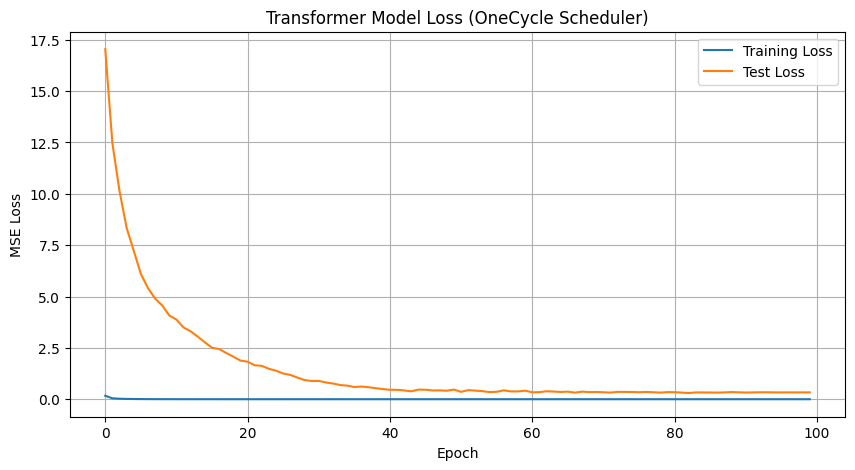

In [51]:
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn as nn

# --- Explicitly Re-initialize Model ---
# This ensures we start with fresh weights every time we run this cell
model_transformer = TimeSeriesTransformer(
    input_dim=input_dim,
    d_model=d_model,
    num_heads=num_heads,
    num_layers=num_layers,
    output_dim=output_dim,
    dropout=0.2,
    dim_feedforward=dim_feedforward
).to(device)

criterion = nn.MSELoss()
# --------------------------------------

# 1. Initialize Optimizer
# Start with a lower initial LR, let the scheduler handle the peak
optimizer = optim.AdamW(model_transformer.parameters(), lr=1e-3, weight_decay=1e-4)

# 2. Training Loop Configuration
num_epochs = 100
train_losses = []
test_losses = []

# 3. Scheduler (OneCycleLR)
# This handles both Warm-up and Decay automatically
total_steps = len(train_loader) * num_epochs
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-3,              # Peak Learning Rate
    total_steps=total_steps,
    pct_start=0.3,            # Warm up for 30% of the time
    div_factor=25,            # Initial LR = max_lr / 25
    final_div_factor=1000     # Final LR = max_lr / (25 * 1000)
)

print(f"Starting training for {num_epochs} epochs on {device} with OneCycleLR...")

for epoch in range(num_epochs):
    # --- Training Phase ---
    model_transformer.train()
    running_train_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model_transformer(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()

        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model_transformer.parameters(), 1.0)

        optimizer.step()
        scheduler.step() # Update LR per batch

        running_train_loss += loss.item() * X_batch.size(0)

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # --- Validation Phase ---
    model_transformer.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model_transformer(X_batch)
            loss = criterion(outputs, y_batch)
            running_test_loss += loss.item() * X_batch.size(0)

    epoch_test_loss = running_test_loss / len(test_loader.dataset)
    test_losses.append(epoch_test_loss)

    current_lr = scheduler.get_last_lr()[0]
    print(f"Epoch [{epoch+1}/{num_epochs}] | LR: {current_lr:.6f} | Train Loss: {epoch_train_loss:.6f} | Test Loss: {epoch_test_loss:.6f}")

print("Training finished.")

# 3. Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Transformer Model Loss (OneCycle Scheduler)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

## Evaluate Model Metrics


In [52]:
# 1. Select 'aapl' data
stock_symbol = 'aapl'
# Filter from merged df
aapl_df = df_merged[df_merged['stock_symbol'] == stock_symbol].sort_values('date')

# Extract raw features
features_aapl = aapl_df[['open', 'close', 'volume', 'sentiment_score']].values

# 2. Identify split index & Convert to Float
split_idx = int(len(features_aapl) * 0.8)
# Important: Convert to float to handle NaNs and subsequent math
train_features_aapl = features_aapl[:split_idx].astype(float)
test_features_aapl = features_aapl[split_idx:].astype(float)

# --- IMPUTATION LOGIC (Replicated for AAPL) ---
# Constants used in training
alpha = np.exp(-0.03)
neutral_score = 3.0

# Ensure helper function exists (in case cell was run out of order)
if 'impute_decay' not in locals():
    def impute_decay(values, start_val, alpha, neutral):
        imputed = []
        current = start_val
        for v in values:
            if np.isnan(v):
                current = alpha * current + (1 - alpha) * neutral
            else:
                current = v
            imputed.append(current)
        return np.array(imputed)

# Impute Train Sentiment (Column 3)
train_sent = train_features_aapl[:, 3]
# Initialize first if NaN
if np.isnan(train_sent[0]):
    train_sent[0] = neutral_score
train_features_aapl[:, 3] = impute_decay(train_sent, neutral_score, alpha, neutral_score)

# Impute Test Sentiment
last_train_score = train_features_aapl[-1, 3]
test_sent = test_features_aapl[:, 3]
test_features_aapl[:, 3] = impute_decay(test_sent, last_train_score, alpha, neutral_score)
# ----------------------------------------------

# 3. Scale using a NEW scaler fitted on the 4-feature training data
scaler_aapl = MinMaxScaler()
scaler_aapl.fit(train_features_aapl)

# Update global dictionary
scalers[stock_symbol] = scaler_aapl

test_scaled_aapl = scaler_aapl.transform(test_features_aapl)

# 4. Generate sequences
# Target 'close' is at index 1
test_target_aapl = test_scaled_aapl[:, 1]
X_test_aapl, y_test_aapl = create_sequences(test_scaled_aapl, test_target_aapl, lookback=50, horizon=3)

print(f"AAPL Data Prepared with Imputation. Test shape: {X_test_aapl.shape}")

AAPL Data Prepared with Imputation. Test shape: (2119, 50, 4)


Transformer Model Evaluation on Test Set:
Mean Squared Error (MSE): 0.333217
Mean Absolute Error (MAE): 0.390098
R2 Score: 0.867974


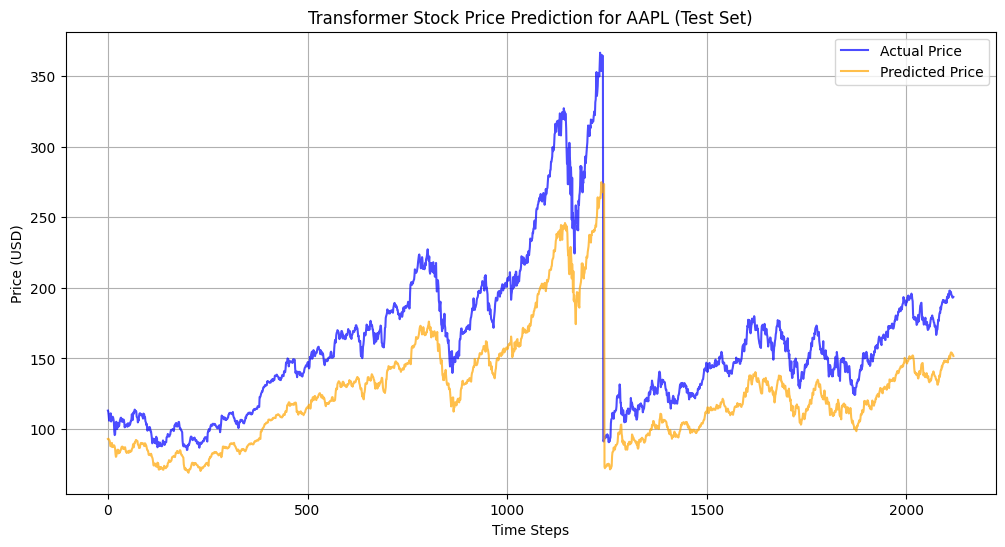

In [53]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# 1. Set model to evaluation mode
model_transformer.eval()

# 2. Generate predictions on the entire test set
with torch.no_grad():
    test_input = X_test_tensor.to(device)
    test_predictions = model_transformer(test_input).cpu().numpy()

# 3. Calculate Metrics
flattened_predictions = test_predictions.flatten()
mse = mean_squared_error(y_test, flattened_predictions)
mae = mean_absolute_error(y_test, flattened_predictions)
r2 = r2_score(y_test, flattened_predictions)

print("Transformer Model Evaluation on Test Set:")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R2 Score: {r2:.6f}")

# 4. Visualization for AAPL
# Reuse the AAPL test data prepared earlier: X_test_tensor_aapl
# Ensure it is on the correct device
X_test_tensor_aapl = torch.tensor(X_test_aapl, dtype=torch.float32).to(device)

with torch.no_grad():
    predictions_aapl = model_transformer(X_test_tensor_aapl).cpu().numpy()

# Inverse Transform
# FIX: Scaler expects 4 features (Open, Close, Vol, Sentiment), so placeholders must have 4 columns
pred_extended = np.zeros((len(predictions_aapl), 4))
actual_extended = np.zeros((len(y_test_aapl), 4))
pred_extended[:, 1] = predictions_aapl.flatten()
actual_extended[:, 1] = y_test_aapl

scaler_aapl = scalers['aapl'] # Ensure we use the correct scaler
inverse_pred = scaler_aapl.inverse_transform(pred_extended)[:, 1]
inverse_actual = scaler_aapl.inverse_transform(actual_extended)[:, 1]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(inverse_actual, label='Actual Price', color='blue', alpha=0.7)
plt.plot(inverse_pred, label='Predicted Price', color='orange', alpha=0.7)
plt.title(f'Transformer Stock Price Prediction for AAPL (Test Set)')
plt.xlabel('Time Steps')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()